In [27]:
import random
import time
import networkx as nx
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [28]:

# Random graph generation function (with random number of vertices and edges)
def generate_random_graph(min_vertices, max_vertices, max_degree, min_edges, max_edges):
    # Randomly select the number of vertices within the specified range
    num_vertices = random.randint(min_vertices, max_vertices)
    
    # Randomly select the number of edges within the specified range
    num_edges = random.randint(min_edges, max_edges)
    
    if max_degree >= num_vertices:
        raise ValueError("max_degree must be less than the number of vertices for a simple graph.")
    
    adjacency = defaultdict(set)

    # Try to add edges until the number of edges reaches the limit or all degrees are within the limit
    attempts = 0
    max_attempts = num_vertices * max_degree * 2  # avoid infinite loop

    while attempts < max_attempts and sum(len(neighbors) for neighbors in adjacency.values()) // 2 < num_edges:
        u = random.randint(0, num_vertices - 1)
        v = random.randint(0, num_vertices - 1)

        if u == v:
            attempts += 1
            continue  # no self-loops

        if v in adjacency[u] or u in adjacency[v]:
            attempts += 1
            continue  # no duplicate edges

        if len(adjacency[u]) >= max_degree or len(adjacency[v]) >= max_degree:
            attempts += 1
            continue  # respect max degree

        # Add edge
        adjacency[u].add(v)
        adjacency[v].add(u)

    # Calculate number of edges
    num_edges_generated = sum(len(neighbors) for neighbors in adjacency.values()) // 2  # undirected graph

    # Calculate average degree
    total_degree = sum(len(neighbors) for neighbors in adjacency.values())
    avg_degree = total_degree / num_vertices if num_vertices > 0 else 0

    # Convert sets to sorted lists for prettier output
    return {
        "graph": {k: sorted(list(vs)) for k, vs in adjacency.items()},
        "num_vertices": num_vertices,
        "num_edges": num_edges_generated,
        "avg_degree": avg_degree
    }

In [29]:
# Greedy Random Order Maximal Matching (ROGMM)
def rogmm_matching(graph):
    # Create a set to store the matching
    matching = set()
    vertices = list(graph.keys())
    random.shuffle(vertices)  # Randomize the order of vertices
    
    matched = set()  # Keep track of matched vertices
    for u in vertices:
        if u not in matched:
            for v in graph[u]:
                if v not in matched:
                    matching.add((u, v))
                    matched.add(u)
                    matched.add(v)
                    break

    return matching

In [30]:
# Optimal matching using Blossom algorithm (via NetworkX)
def optimal_matching(graph):
    # Create a NetworkX graph
    G = nx.Graph()
    
    # Add edges to the graph
    for u, neighbors in graph.items():
        for v in neighbors:
            if u < v:  # Prevent adding duplicate edges (undirected graph)
                G.add_edge(u, v)
    
    # Find the maximum matching using the Blossom algorithm
    matching = nx.max_weight_matching(G, maxcardinality=True, weight=None)

    return matching

In [31]:
# Run the comparison experiment
def compare_algorithms(num_graphs, min_vertices, max_vertices, max_degree, min_edges, max_edges):
    rogmm_results = []
    optimal_results = []
    
    for _ in range(num_graphs):
        # Generate a random graph with random vertices and edges
        result = generate_random_graph(min_vertices, max_vertices, max_degree, min_edges, max_edges)
        graph = result['graph']

        # Run Greedy Random Order Maximal Matching (ROGMM)
        start_time = time.time()
        rogmm_matching_result = rogmm_matching(graph)
        rogmm_time = time.time() - start_time
        rogmm_results.append({
            'matching_size': len(rogmm_matching_result),
            'runtime': rogmm_time,
            'num_vertices': result['num_vertices'],
            'num_edges': result['num_edges'],
            'avg_degree': result['avg_degree']
        })

        # Run Optimal Matching (using Blossom algorithm)
        start_time = time.time()
        optimal_matching_result = optimal_matching(graph)
        optimal_time = time.time() - start_time
        optimal_results.append({
            'matching_size': len(optimal_matching_result),
            'runtime': optimal_time,
            'num_vertices': result['num_vertices'],
            'num_edges': result['num_edges'],
            'avg_degree': result['avg_degree']
        })
    
    return rogmm_results, optimal_results

In [32]:
# Analyze and display results
def analyze_results(rogmm_results, optimal_results):
    
    # Convert the results into DataFrames for easier analysis
    rogmm_df = pd.DataFrame(rogmm_results)
    optimal_df = pd.DataFrame(optimal_results)

    # Show basic statistics
    print("ROGMM Results:")
    print(rogmm_df.describe())
    print("\nOptimal Matching Results:")
    print(optimal_df.describe())

    # Compare matching sizes and runtimes
    print("\nAverage Matching Sizes:")
    print(f"ROGMM: {rogmm_df['matching_size'].mean():.2f}")
    print(f"Optimal: {optimal_df['matching_size'].mean():.2f}")

    print("\nAverage Runtime (seconds):")
    print(f"ROGMM: {rogmm_df['runtime'].mean():.4f}")
    print(f"Optimal: {optimal_df['runtime'].mean():.4f}")


In [33]:
def visualize_results(rogmm_results, optimal_results):
    # Convert results to DataFrames
    rogmm_df = pd.DataFrame(rogmm_results)
    optimal_df = pd.DataFrame(optimal_results)

    # Plot Matching Size vs Average Degree
    plt.figure(figsize=(12, 6))

    # Plot Greedy Random Order Maximal Matching
    plt.subplot(1, 2, 1)
    plt.scatter(rogmm_df['avg_degree'], rogmm_df['matching_size'], color='blue', alpha=0.5, label='ROGMM')
    plt.scatter(optimal_df['avg_degree'], optimal_df['matching_size'], color='red', alpha=0.5, label='Optimal')
    plt.title('Matching Size vs Average Degree')
    plt.xlabel('Average Degree')
    plt.ylabel('Matching Size')
    plt.legend()

    # Plot Runtime vs Average Degree
    plt.subplot(1, 2, 2)
    plt.scatter(rogmm_df['avg_degree'], rogmm_df['runtime'], color='blue', alpha=0.5, label='ROGMM')
    plt.scatter(optimal_df['avg_degree'], optimal_df['runtime'], color='red', alpha=0.5, label='Optimal')
    plt.title('Runtime vs Average Degree')
    plt.xlabel('Average Degree')
    plt.ylabel('Runtime (seconds)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [34]:
def compute_and_visualize_ratio(rogmm_results, optimal_results):
    # Convert results to DataFrames
    rogmm_df = pd.DataFrame(rogmm_results)
    optimal_df = pd.DataFrame(optimal_results)

    # Compute the ratio of ROGMM to Optimal matching sizes
    ratios = []
    for i in range(len(rogmm_df)):
        rogmm_size = rogmm_df['matching_size'].iloc[i]
        optimal_size = optimal_df['matching_size'].iloc[i]
        
        # Compute ratio only if optimal size is greater than 0 to avoid division by zero
        if optimal_size > 0:
            ratio = rogmm_size / optimal_size
        else:
            ratio = float('inf')  # If optimal size is 0, use infinity (should be rare)
        
        ratios.append(ratio)
    
    # Add the ratio to the DataFrame
    rogmm_df['optimal_matching_size'] = optimal_df['matching_size'].values
    rogmm_df['ratio'] = ratios

    # Plot Ratio vs Average Degree
    plt.figure(figsize=(8, 6))
    plt.scatter(rogmm_df['avg_degree'], rogmm_df['ratio'], color='green', alpha=0.5)
    plt.title('ROGMM to Optimal Matching Size Ratio vs Average Degree')
    plt.xlabel('Average Degree')
    plt.ylabel('ROGMM / Optimal Matching Size Ratio')
    plt.grid(True)
    plt.show()

    # Display the statistics for the ratio
    print(f"Average Ratio of ROGMM to Optimal Matching Size: {rogmm_df['ratio'].mean():.2f}")
    print(f"Maximum Ratio of ROGMM to Optimal Matching Size: {rogmm_df['ratio'].max():.2f}")
    print(f"Minimum Ratio of ROGMM to Optimal Matching Size: {rogmm_df['ratio'].min():.2f}")

ROGMM Results:
       matching_size       runtime  num_vertices     num_edges    avg_degree
count    10000.00000  10000.000000   10000.00000  10000.000000  10000.000000
mean         3.55970      0.000005       9.96210      9.199700      1.985526
std          1.09314      0.000001       3.15323      2.827334      0.661969
min          1.00000      0.000002       5.00000      5.000000      0.666667
25%          3.00000      0.000004       7.00000      7.000000      1.428571
50%          3.00000      0.000005      10.00000      9.000000      2.000000
75%          4.00000      0.000006      13.00000     11.000000      2.666667
max          7.00000      0.000027      15.00000     15.000000      3.000000

Optimal Matching Results:
       matching_size       runtime  num_vertices     num_edges    avg_degree
count   10000.000000  10000.000000   10000.00000  10000.000000  10000.000000
mean        3.890000      0.000124       9.96210      9.199700      1.985526
std         1.194003      0.000922

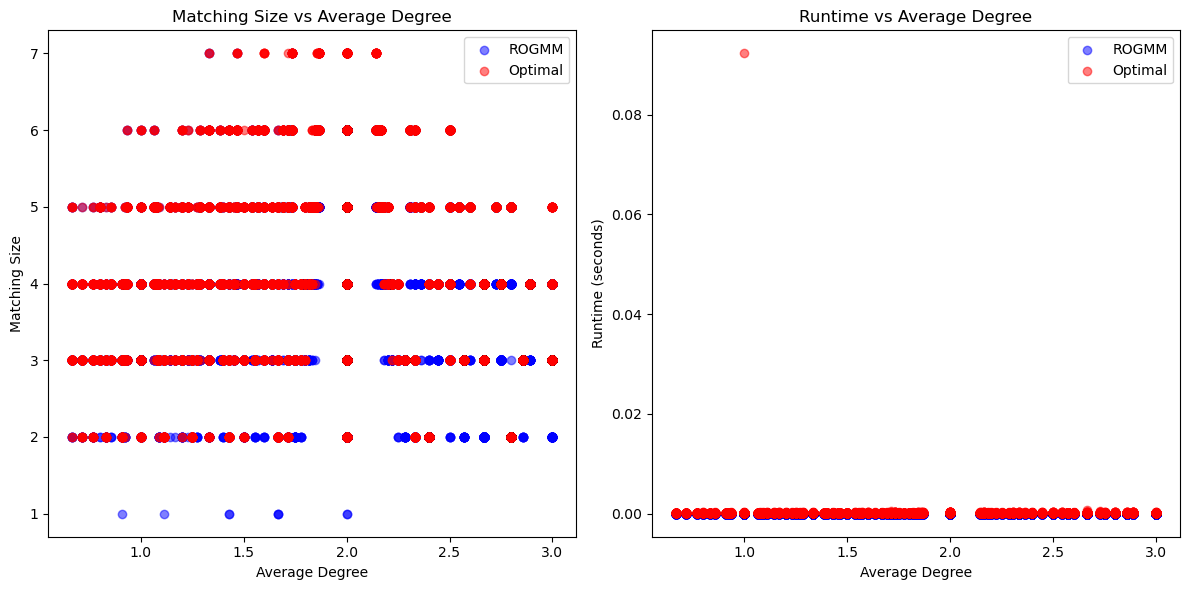

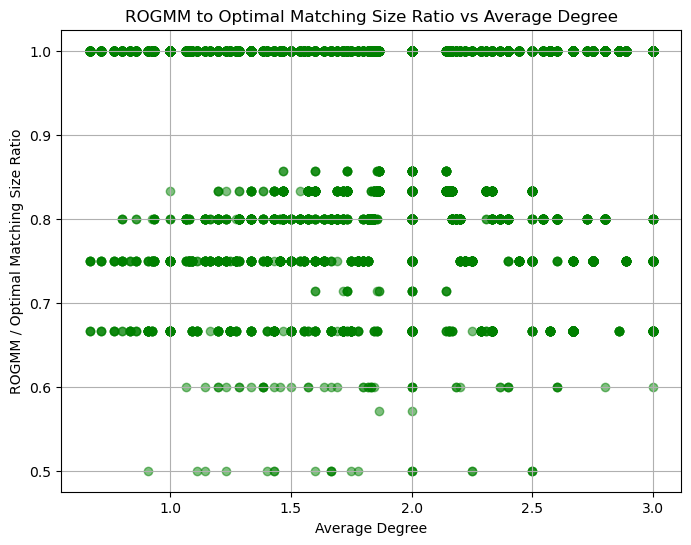

Average Ratio of ROGMM to Optimal Matching Size: 0.92
Maximum Ratio of ROGMM to Optimal Matching Size: 1.00
Minimum Ratio of ROGMM to Optimal Matching Size: 0.50


In [44]:
num_graphs = 10000  # Number of graphs to generate
min_vertices = 5  # Minimum number of vertices in each graph
max_vertices = 15  # Maximum number of vertices in each graph
max_degree = 3  # Maximum degree of vertices
min_edges = 5  # Minimum number of edges
max_edges = 15  # Maximum number of edges

# Run the comparison
rogmm_results, optimal_results = compare_algorithms(num_graphs, min_vertices, max_vertices, max_degree, min_edges, max_edges)

analyze_results(rogmm_results, optimal_results)

visualize_results(rogmm_results, optimal_results)

compute_and_visualize_ratio(rogmm_results, optimal_results)

In [37]:
# Compute graph properties
def compute_graph_properties(graph):
    G = nx.Graph()
    for u, neighbors in graph.items():
        for v in neighbors:
            if u < v:
                G.add_edge(u, v)

    # Properties
    avg_degree = sum(dict(G.degree()).values()) / len(G) if len(G) > 0 else 0
    density = nx.density(G)
    is_bipartite = nx.is_bipartite(G)
    num_components = nx.number_connected_components(G)
    has_cycles = len(list(nx.simple_cycles(G))) > 0

    return {
        "avg_degree": avg_degree,
        "density": density,
        "is_bipartite": is_bipartite,
        "num_components": num_components,
        "has_cycles": has_cycles
    }

In [63]:
def analyze_properties(num_graphs, min_vertices, max_vertices, max_degree, min_edges, max_edges):
    ratios = []
    properties = []
    all_graphs = []

    for i in range(num_graphs):
        result = generate_random_graph(min_vertices, max_vertices, max_degree, min_edges, max_edges)
        graph = result['graph']
        all_graphs.append(graph)

        # Compute properties using NetworkX
        G_nx = nx.Graph()
        for u, neighbors in graph.items():
            for v in neighbors:
                if u < v:
                    G_nx.add_edge(u, v)

        avg_degree = result['avg_degree']
        density = nx.density(G_nx)
        is_bipartite = nx.is_bipartite(G_nx)
        num_components = nx.number_connected_components(G_nx)

        # Run algorithms
        rogmm_size = len(rogmm_matching(graph))
        optimal_size = len(optimal_matching(graph))
        ratio = rogmm_size / optimal_size if optimal_size > 0 else float("inf")

        # Print graph info
        print(f"\n--- Graph {i+1} ---")
        print("Adjacency List:")
        for node in sorted(graph.keys()):
            print(f"  {node}: {graph[node]}")
        print(f"Density: {density:.3f}")
        print(f"ROGMM/Optimal Ratio: {ratio:.3f}")

        # Save data
        properties.append({
            "avg_degree": avg_degree,
            "density": density,
            "is_bipartite": is_bipartite,
            "num_components": num_components,
            "ratio": ratio
        })

    # Convert to DataFrame
    df = pd.DataFrame(properties)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].scatter(df['avg_degree'], df['ratio'], alpha=0.5)
    axes[0, 0].set_title("Average Degree vs Ratio")
    axes[0, 0].set_xlabel("Average Degree")
    axes[0, 0].set_ylabel("Ratio")

    axes[0, 1].scatter(df['density'], df['ratio'], alpha=0.5)
    axes[0, 1].set_title("Density vs Ratio")
    axes[0, 1].set_xlabel("Density")

    axes[1, 0].scatter(df['is_bipartite'], df['ratio'], alpha=0.5)
    axes[1, 0].set_title("Bipartite vs Ratio")
    axes[1, 0].set_xlabel("Is Bipartite")

    axes[1, 1].scatter(df['num_components'], df['ratio'], alpha=0.5)
    axes[1, 1].set_title("Components vs Ratio")
    axes[1, 1].set_xlabel("Number of Components")

    plt.tight_layout()
    plt.show()

    return df


--- Graph 1 ---
Adjacency List:
  1: [18, 22]
  4: [11]
  10: [21]
  11: [4]
  14: [15, 24]
  15: [14, 16]
  16: [15]
  18: [1]
  21: [10]
  22: [1]
  24: [14]
Density: 0.127
ROGMM/Optimal Ratio: 0.800

--- Graph 2 ---
Adjacency List:
  0: [2]
  2: [0, 20, 21]
  4: [14]
  6: [25]
  7: [10]
  10: [7, 22, 23]
  11: [15]
  14: [4, 22]
  15: [11]
  16: [21]
  20: [2, 26]
  21: [2, 16, 26]
  22: [10, 14]
  23: [10]
  25: [6]
  26: [20, 21]
Density: 0.108
ROGMM/Optimal Ratio: 1.000

--- Graph 3 ---
Adjacency List:
  1: [13]
  2: [11, 21]
  3: [12]
  5: [6, 14]
  6: [5]
  7: [8]
  8: [7]
  9: [17]
  11: [2]
  12: [3]
  13: [1, 18]
  14: [5]
  17: [9]
  18: [13]
  19: [22]
  21: [2]
  22: [19]
Density: 0.074
ROGMM/Optimal Ratio: 1.000

--- Graph 4 ---
Adjacency List:
  1: [17]
  2: [12]
  5: [9]
  6: [9, 10]
  7: [12]
  8: [9]
  9: [5, 6, 8]
  10: [6]
  12: [2, 7]
  17: [1]
Density: 0.156
ROGMM/Optimal Ratio: 1.000

--- Graph 5 ---
Adjacency List:
  0: [27]
  2: [25]
  3: [7]
  7: [3, 26]
  8

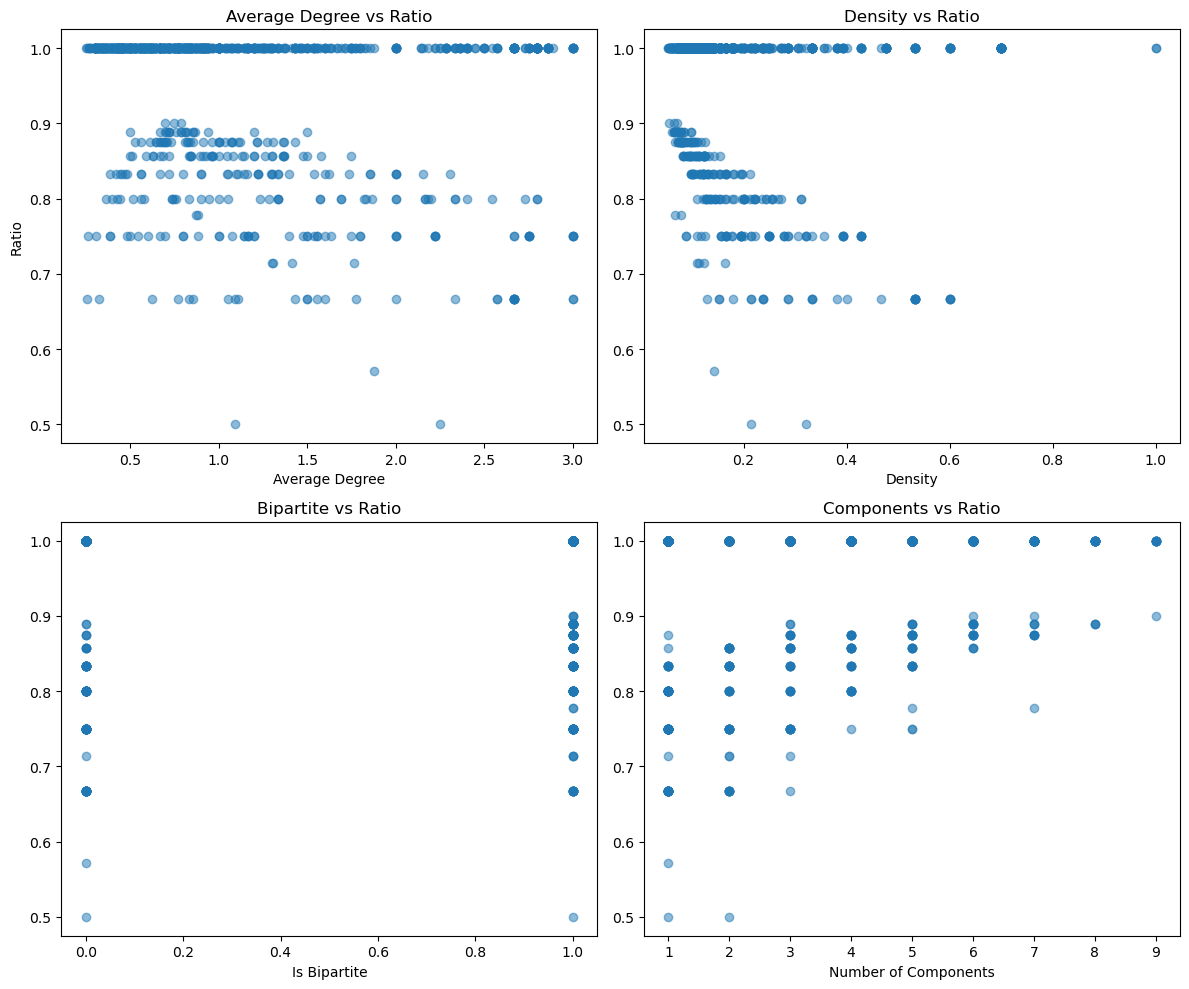

   avg_degree   density  is_bipartite  num_components  ratio
0    0.560000  0.127273          True               4    0.8
1    0.896552  0.108333          True               4    1.0
2    0.869565  0.073529          True               7    1.0
3    0.777778  0.155556          True               3    1.0
4    0.580645  0.085714          True               6    1.0


In [70]:
if __name__ == "__main__":
    num_graphs = 1000  # Number of graphs to generate
    min_vertices = 5  # Minimum number of vertices in each graph
    max_vertices = 40  # Maximum number of vertices in each graph
    max_degree = 3  # Maximum degree of vertices
    min_edges = 5  # Minimum number of edges
    max_edges = 15  # Maximum number of edges

    # Run the experiment and analyze properties
    data = analyze_properties(num_graphs, min_vertices, max_vertices, max_degree, min_edges, max_edges)

    # Display the data
    print(data.head())